In [4]:
from sqlalchemy import create_engine

In [5]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


# Reflect Tables into SQLAlchemy ORM

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# Reflect an existing database into a new model
Base = automap_base()
# Reflect the tables
Base.prepare(engine, reflect=True)

# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

# Create our session (link) from Python to the DB
session = Session(engine)



In [8]:
# Close the session
session.close()


In [9]:
# View all of the classes that automap found
# Reflect an existing database into a new model
Base = automap_base()
# Reflect the tables
Base.prepare(engine, reflect=True)

# View all of the classes that automap found
classes = Base.classes.keys()
print(classes)


['measurement', 'station']


In [10]:
# Save references to each table

# Reflect an existing database into a new model
Base = automap_base()
# Reflect the tables
Base.prepare(engine, reflect=True)

# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent_date)


('2017-08-23',)


<Figure size 1000x600 with 0 Axes>

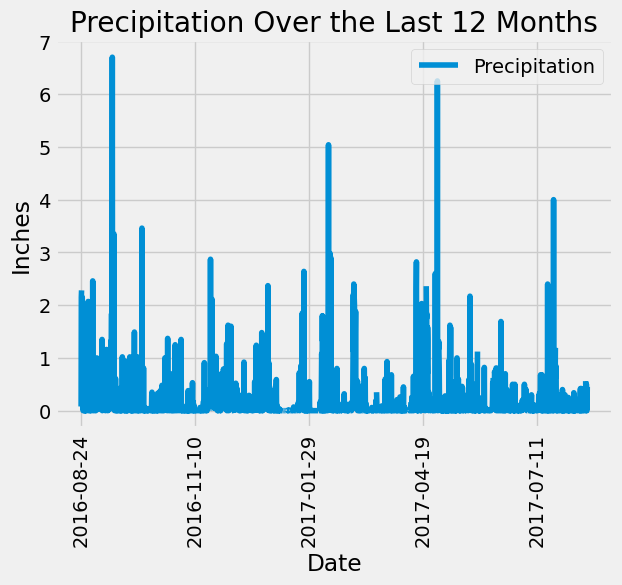

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# 1. Calculate the date one year from the last date in data set
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent_date = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")
one_year_ago = most_recent_date - dt.timedelta(days=365)

# 2. Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# 3. Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])
df.set_index('Date', inplace=True)

# 4. Sort the dataframe by date
df = df.sort_index()

# 5. Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
df.plot(title="Precipitation Over the Last 12 Months", xlabel="Date", ylabel="Inches")
plt.xticks(rotation=90)
plt.legend(loc='upper right')
plt.show()


In [14]:
# Calculate the summary statistics for the precipitation data
summary_statistics = df.describe()
print(summary_statistics)


       Precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [15]:
# Calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")


Total number of stations: 9


In [18]:
# Design a query to find the most active stations (i.e., which stations have the most rows?)
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).all()

# List the stations and their counts in descending order
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")


Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [19]:
# most_active_stations is my query result from the previous step
most_active_station_id = most_active_stations[0][0]  # This gets the station ID of the most active station

# Calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), 
                                  func.max(Measurement.tobs), 
                                  func.avg(Measurement.tobs)).\
                    filter(Measurement.station == most_active_station_id).all()

# Extract the results
lowest_temp, highest_temp, average_temp = temperature_stats[0]

print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {round(average_temp, 2)}")



Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66


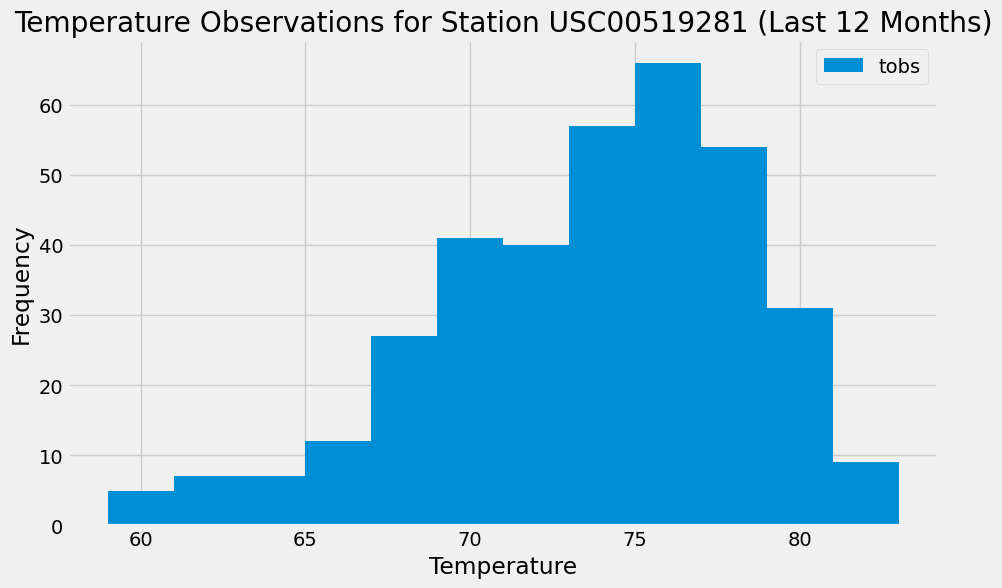

In [20]:
# Calculate the date one year from the last date in the dataset for the most active station
most_recent_date = session.query(Measurement.date).\
                    filter(Measurement.station == most_active_station_id).\
                    order_by(Measurement.date.desc()).first()[0]

# Convert string date to datetime object
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year ago
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Query the last 12 months of temperature observation data for this station
temperature_data_last_year = session.query(Measurement.tobs).\
                             filter(Measurement.station == most_active_station_id).\
                             filter(Measurement.date >= one_year_ago).all()

# Convert query results to a list of temperatures
temperatures = [temp[0] for temp in temperature_data_last_year]

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperatures, bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f"Temperature Observations for Station {most_active_station_id} (Last 12 Months)")
plt.legend()
plt.show()


# Close Session

In [21]:
# Close Session
session.close()